# Exploring the MHW DB

In [54]:
# imports
import numpy as np
import os
from matplotlib import pyplot as plt

import pandas
import sqlalchemy
import iris
import iris.quickplot as qplt

In [51]:
%matplotlib notebook

In [42]:
def match_ids(IDs, match_IDs, require_in_match=True):
    """ Match input IDs to another array of IDs (usually in a table)
    Return the rows aligned with input IDs

    Parameters
    ----------
    IDs : ndarray
    match_IDs : ndarray
    require_in_match : bool, optional
      Require that each of the input IDs occurs within the match_IDs

    Returns
    -------
    rows : ndarray
      Rows in match_IDs that match to IDs, aligned
      -1 if there is no match

    """
    rows = -1 * np.ones_like(IDs).astype(int)
    # Find which IDs are in match_IDs
    in_match = np.in1d(IDs, match_IDs)
    if require_in_match:
        if np.sum(~in_match) > 0:
            raise IOError("qcat.match_ids: One or more input IDs not in match_IDs")
    rows[~in_match] = -1
    #
    IDs_inmatch = IDs[in_match]
    # Find indices of input IDs in meta table -- first instance in meta only!
    xsorted = np.argsort(match_IDs)
    ypos = np.searchsorted(match_IDs, IDs_inmatch, sorter=xsorted)
    indices = xsorted[ypos]
    rows[in_match] = indices
    return rows


# Load up

In [8]:
mhw_file = '/home/xavier/Projects/Oceanography/MHWs/db/mhws_allsky_defaults.db'

In [9]:
engine = sqlalchemy.create_engine('sqlite:///'+mhw_file)

In [10]:
connection = engine.connect()
connection

# Table time

In [11]:
pd_tbl = pandas.read_sql_table('MHW_Events', con=engine, columns=['lon', 'lat', 'duration'])

In [12]:
pd_tbl

,lon,lat,duration
0,0.125,-65.125,13
1,0.125,-65.125,33
2,0.125,-65.125,10
3,0.125,-65.125,9
4,0.125,-65.125,52
...,...,...,...
283678,86.125,77.375,21
283679,86.125,77.375,8
283680,86.125,77.375,182
283681,86.125,77.375,43


# Make a Cube

## Coords from an existing

In [35]:
noaa_path = '/home/xavier/Projects/Oceanography/data/SST/NOAA-OI-SST-V2/'

In [38]:
file_1982 = os.path.join(noaa_path, 'sst.day.mean.1982.nc')
cubes_1982 = iris.load(file_1982)
sst_1982 = cubes_1982[0]

In [40]:
lat_coord = sst_1982.coord('latitude')
lon_coord = sst_1982.coord('longitude')

## Number of events

In [39]:
ulats = np.unique(pd_tbl['lat'])
ulons = np.unique(pd_tbl['lon'])

In [61]:
ulats

array([-87.625, -85.125, -82.625, -80.125, -70.125, -67.625, -65.125,
       -62.625, -60.125, -57.625, -55.125, -52.625, -50.125, -47.625,
       -45.125, -42.625, -40.125, -37.625, -35.125, -32.625, -30.125,
       -27.625, -25.125, -22.625, -20.125, -17.625, -15.125, -12.625,
       -10.125,  -7.625,  -5.125,  -2.625,  -0.125,   2.375,   4.875,
         7.375,   9.875,  12.375,  14.875,  17.375,  19.875,  22.375,
        24.875,  27.375,  29.875,  32.375,  34.875,  37.375,  39.875,
        42.375,  44.875,  47.375,  49.875,  52.375,  54.875,  57.375,
        59.875,  62.375,  64.875,  67.375,  69.875,  72.375,  74.875,
        77.375,  79.875,  82.375,  84.875,  87.375,  89.875])

In [41]:
n_events.shape

(720, 1440)

In [46]:
i_idx = match_ids(pd_tbl['lat'], lat_coord.points, require_in_match=True)
j_idx = match_ids(pd_tbl['lon'], lon_coord.points, require_in_match=True)
i_idx, j_idx

(array([ 99,  99,  99, ..., 669, 669, 669]),
 array([  0,   0,   0, ..., 344, 344, 344]))

In [47]:
n_events  = np.zeros((lat_coord.shape[0], lon_coord.shape[0]))
for ii, jj in zip(i_idx, j_idx):
    n_events[ii,jj] += 1

In [19]:
lon_coord = iris.coords.DimCoord(lons, standard_name='longitude')
lat_coord = iris.coords.DimCoord(lats, standard_name='latitude')

In [49]:
cube = iris.cube.Cube(n_events, var_name='N_events',
                                     dim_coords_and_dims=[(lat_coord, 0),
                                                          (lon_coord, 1)])

In [50]:
cube

N Events (unknown),latitude,longitude
Shape,720,1440
Dimension coordinates,,
latitude,x,-
longitude,-,x


# Plot

In [56]:
np.max(cube.data)

117.0

<IPython.core.display.Javascript object>


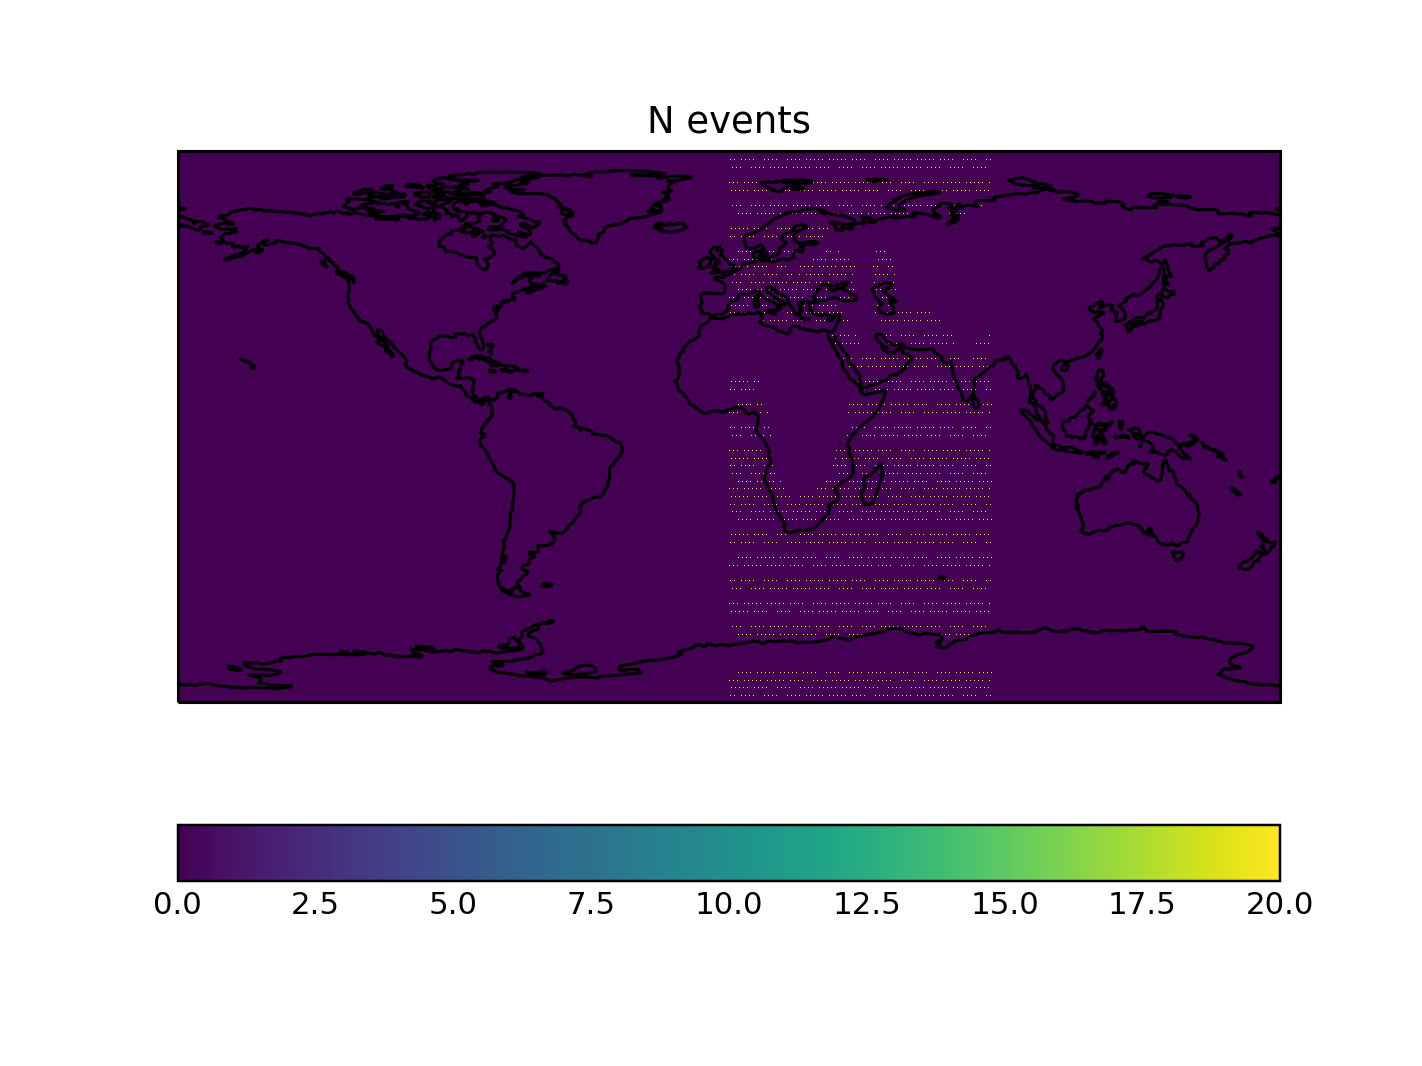

In [59]:
# Draw the contour with 25 levels.
qplt.pcolormesh(cube,vmin=0, vmax=20)#, 5)

# Add coastlines to the map created by contourf.
plt.gca().coastlines()

plt.show()

----